<a href="https://colab.research.google.com/github/KaraniWachira/delivery_insights/blob/main/delivery_insights.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import statistics
from geopy.distance import geodesic

from sklearn.model_selection import train_test_split,cross_val_score, GridSearchCV
from sklearn.preprocessing import LabelEncoder,StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
import xgboost as XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score,mean_absolute_error

import warnings
warnings.filterwarnings('ignore')

In [ ]:
df_train = pd.read_csv("/content/drive/MyDrive/food_delivery_dataset/train.csv")

df_train.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45593 entries, 0 to 45592
Data columns (total 20 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   ID                           45593 non-null  object 
 1   Delivery_person_ID           45593 non-null  object 
 2   Delivery_person_Age          45593 non-null  object 
 3   Delivery_person_Ratings      45593 non-null  object 
 4   Restaurant_latitude          45593 non-null  float64
 5   Restaurant_longitude         45593 non-null  float64
 6   Delivery_location_latitude   45593 non-null  float64
 7   Delivery_location_longitude  45593 non-null  float64
 8   Order_Date                   45593 non-null  object 
 9   Time_Orderd                  45593 non-null  object 
 10  Time_Order_picked            45593 non-null  object 
 11  Weatherconditions            45593 non-null  object 
 12  Road_traffic_density         45593 non-null  object 
 13  Vehicle_conditio

In [ ]:
#Summary Statistics for numerical columns
df_train.describe().T

count       mean        std        min  \
Restaurant_latitude          45593.0  17.017729   8.185109 -30.905562   
Restaurant_longitude         45593.0  70.231332  22.883647 -88.366217   
Delivery_location_latitude   45593.0  17.465186   7.335122   0.010000   
Delivery_location_longitude  45593.0  70.845702  21.118812   0.010000   
Vehicle_condition            45593.0   1.023359   0.839065   0.000000   

                                   25%        50%        75%        max  
Restaurant_latitude          12.933284  18.546947  22.728163  30.914057  
Restaurant_longitude         73.170000  75.898497  78.044095  88.433452  
Delivery_location_latitude   12.988453  18.633934  22.785049  31.054057  
Delivery_location_longitude  73.280000  76.002574  78.107044  88.563452  
Vehicle_condition             0.000000   1.000000   2.000000   3.000000

In [ ]:
#Summary Statistics for non-numerical columns
df_train.describe(exclude=np.number).T

count unique              top   freq
ID                       45593  45593          0x4607       1
Delivery_person_ID       45593   1320  PUNERES01DEL01      67
Delivery_person_Age      45593     23               35   2262
Delivery_person_Ratings  45593     29              4.8   7148
Order_Date               45593     44       15-03-2022   1192
Time_Orderd              45593    177             NaN    1731
Time_Order_picked        45593    193         21:30:00    496
Weatherconditions        45593      7   conditions Fog   7654
Road_traffic_density     45593      5             Low   15477
Type_of_order            45593      4           Snack   11533
Type_of_vehicle          45593      4      motorcycle   26435
multiple_deliveries      45593      5                1  28159
Festival                 45593      3              No   44469
City                     45593      4   Metropolitian   34093
Time_taken(min)          45593     45         (min) 26   2123

In [ ]:
#Change name Weatherconditions to Weather_conditions
df_train.rename(columns={'Weatherconditions': 'Weather_conditions'},inplace=True)



Data Extraction

In [ ]:
def extract_column_value(df):
    # Extract time and convert to int
    df['Time_taken(min)'] = df['Time_taken(min)'].apply(lambda x: int(x.split(' ')[1].strip()) if isinstance(x, str) else x)

    # Extract Weather conditions
    df['Weather_conditions'] = df['Weather_conditions'].apply(lambda x: x.split(' ')[1].strip() if isinstance(x, str) else x)

    # Extract City code
    df['City_code'] = df['Delivery_person_ID'].str.split("RES", expand=True)[0]

# Apply the function to your DataFrame
extract_column_value(df_train)
df_train[['Time_taken(min)', 'Weather_conditions', 'City_code']].head()


Time_taken(min) Weather_conditions City_code
0               24              Sunny      INDO
1               33             Stormy      BANG
2               26         Sandstorms      BANG
3               21              Sunny     COIMB
4               30             Cloudy      CHEN

Update Data Types

In [ ]:
#Update datatypes
def update_datatype(df):
    #Update datatype from object to float
    df['Delivery_person_Age'] = df['Delivery_person_Age'].astype('float64')
    df['Delivery_person_Ratings'] = df['Delivery_person_Ratings'].astype('float64')
    df['multiple_deliveries'] = df['multiple_deliveries'].astype('float64')
    #Update datatype from object to datetime
    df['Order_Date']=pd.to_datetime(df['Order_Date'],format="%d-%m-%Y")

update_datatype(df_train)

Drop Columns

In [ ]:
df_train.drop(['ID','Delivery_person_ID'],axis=1,inplace=True)

Check for Duplicate Values

In [ ]:
#Check for Duplicate Values
if (len(df_train[df_train.duplicated()])>0):
    print("There are Duplicate values present")
else:
    print("There is no duplicate value present")

There is no duplicate value present


Handle Missing Values

In [ ]:
#Replace NaN to np.nan
df_train.replace('NaN', float(np.nan), regex=True,inplace=True)
#Show count of NaN values in data
df_train.isnull().sum().sort_values(ascending=False)

Delivery_person_Ratings        1908
Delivery_person_Age            1854
Time_Orderd                    1731
City                           1200
multiple_deliveries             993
Weather_conditions              616
Road_traffic_density            601
Festival                        228
Order_Date                        0
Delivery_location_longitude       0
Time_Order_picked                 0
Delivery_location_latitude        0
Vehicle_condition                 0
Type_of_order                     0
Type_of_vehicle                   0
Restaurant_longitude              0
Restaurant_latitude               0
Time_taken(min)                   0
City_code                         0
dtype: int64

Data visualization

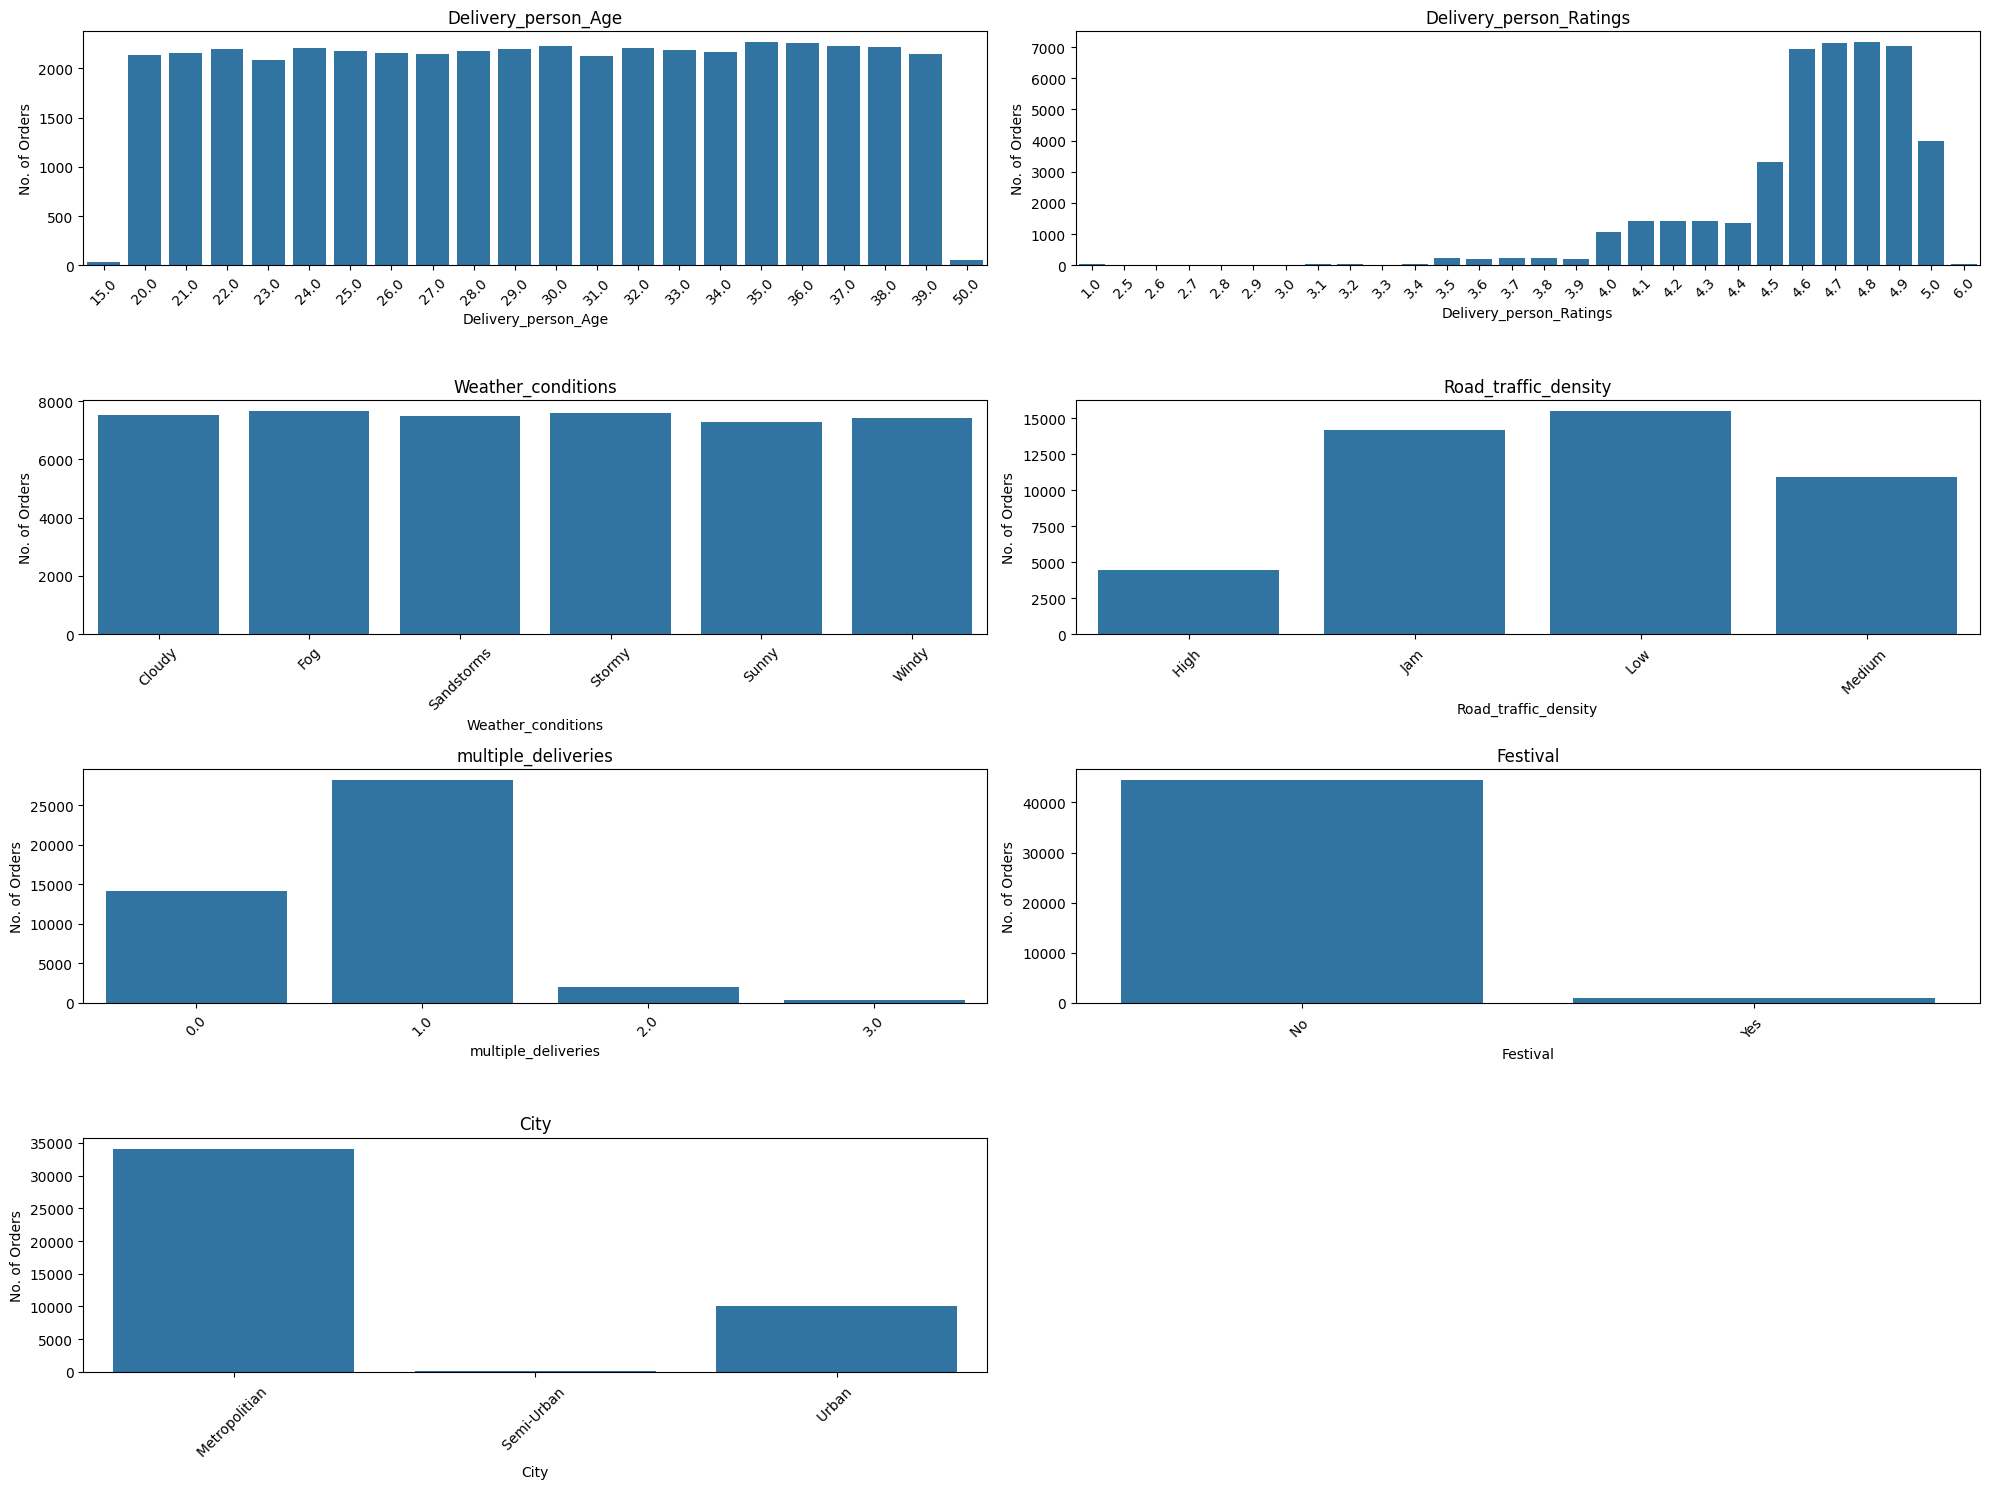

In [ ]:
#Data Visualisation
cols = ['Delivery_person_Age','Delivery_person_Ratings','Weather_conditions','Road_traffic_density','multiple_deliveries','Festival','City']
num_plots = len(cols)
num_rows = (num_plots // 2) + (num_plots % 2)

fig, axes = plt.subplots(num_rows, 2, figsize=(20,15))

for i, column_name in enumerate(cols):
    row = i // 2
    col = i % 2

    ax = axes[row, col]
    sns.countplot(data=df_train, x=column_name, order=df_train[column_name].value_counts().sort_index().index, ax=ax)

    ax.set_xlabel(column_name)
    ax.set_ylabel('No. of Orders')
    ax.set_title(column_name)
    ax.tick_params(axis='x', rotation=45)

if num_plots % 2 != 0:
    fig.delaxes(axes[-1, -1])

plt.tight_layout()
plt.show()

Handle null values

In [ ]:
#Handle null values
def handle_null_values(df):
    df_train['Delivery_person_Age'].fillna(np.random.choice(df['Delivery_person_Age']), inplace=True)
    df_train['Weather_conditions'].fillna(np.random.choice(df['Weather_conditions']), inplace=True)
    df_train['City'].fillna(df['City'].mode()[0], inplace=True)
    df_train['Festival'].fillna(df['Festival'].mode()[0], inplace=True)
    df_train['multiple_deliveries'].fillna(df['multiple_deliveries'].mode()[0], inplace=True)
    df_train['Road_traffic_density'].fillna(df['Road_traffic_density'].mode()[0], inplace=True)
    df_train['Delivery_person_Ratings'].fillna(df['Delivery_person_Ratings'].median(), inplace=True)

handle_null_values(df_train)
df_train.isnull().sum()

Delivery_person_Age               0
Delivery_person_Ratings           0
Restaurant_latitude               0
Restaurant_longitude              0
Delivery_location_latitude        0
Delivery_location_longitude       0
Order_Date                        0
Time_Orderd                    1731
Time_Order_picked                 0
Weather_conditions                0
Road_traffic_density              0
Vehicle_condition                 0
Type_of_order                     0
Type_of_vehicle                   0
multiple_deliveries               0
Festival                          0
City                              0
Time_taken(min)                   0
City_code                         0
dtype: int64

Feature Engineering

In [ ]:
def extract_date_features(data):
    data["day"] = data.Order_Date.dt.day
    data["month"] = data.Order_Date.dt.month
    data["quarter"] = data.Order_Date.dt.quarter
    data["year"] = data.Order_Date.dt.year
    data['day_of_week'] = data.Order_Date.dt.day_of_week.astype(int)
    data["is_month_start"] = data.Order_Date.dt.is_month_start.astype(int)
    data["is_month_end"] = data.Order_Date.dt.is_month_end.astype(int)
    data["is_quarter_start"] = data.Order_Date.dt.is_quarter_start.astype(int)
    data["is_quarter_end"] = data.Order_Date.dt.is_quarter_end.astype(int)
    data["is_year_start"] = data.Order_Date.dt.is_year_start.astype(int)
    data["is_year_end"] = data.Order_Date.dt.is_year_end.astype(int)
    data['is_weekend'] = np.where(data['day_of_week'].isin([5,6]),1,0)

extract_date_features(df_train)

create a new feature that highlights the difference between the order time and the pickup time

In [ ]:
#Calculate Time Differnce
def calculate_time_diff(df):
    # Find the difference between ordered time & picked time
    df['Time_Orderd'] = pd.to_timedelta(df['Time_Orderd'])
    df['Time_Order_picked'] = pd.to_timedelta(df['Time_Order_picked'])
    df['Time_Order_picked_formatted'] = df['Order_Date'] + np.where(df['Time_Order_picked'] < df['Time_Orderd'], pd.DateOffset(days=1), pd.DateOffset(days=0)) + df['Time_Order_picked']
    df['Time_Ordered_formatted'] = df['Order_Date'] + df['Time_Orderd']
    df['order_prepare_time'] = (df['Time_Order_picked_formatted'] - df['Time_Ordered_formatted']).dt.total_seconds() / 60

    # Handle null values by filling with the median
    df['order_prepare_time'].fillna(df['order_prepare_time'].median(), inplace=True)

    # Drop all the time & date related columns
    df.drop(['Time_Orderd', 'Time_Order_picked', 'Time_Ordered_formatted', 'Time_Order_picked_formatted', 'Order_Date'], axis=1, inplace=True)
calculate_time_diff(df_train)

features like order date, order time, and picked time

calculate the distance between the restaurant location and the delivery location and create a new feature called distance

In [ ]:
#Calculate distance between restaurant location & delivery location
def calculate_distance(df):
    df['distance']=np.zeros(len(df))
    restaurant_coordinates=df[['Restaurant_latitude','Restaurant_longitude']].to_numpy()
    delivery_location_coordinates=df[['Delivery_location_latitude','Delivery_location_longitude']].to_numpy()
    df['distance'] = np.array([geodesic(restaurant, delivery) for restaurant, delivery in zip(restaurant_coordinates, delivery_location_coordinates)])
    df['distance']= df['distance'].astype("str").str.extract('(\d+)').astype("int64")

calculate_distance(df_train)

look at the relationship between the time taken to deliver the food and the age of the delivery partner:


In [ ]:
import plotly.express as px

figure = px.scatter(data_frame = df_train,
                    x="Delivery_person_Age",
                    y="Time_taken(min)",
                    size="Time_taken(min)",
                    color = "distance",
                    trendline="ols",
                    title = "Relationship between Time taken and Age")


figure.show()

Observation

There is a linear relationship between the time taken to deliver the food and the age of the delivery partner. It means young delivery partners take less time to deliver the food compared to the elder partners.

Looking at the relationship between the distance and time taken to deliver the food

In [ ]:
import plotly.express as px

figure = px.scatter(data_frame = df_train,
                    x="distance",
                    y="Time_taken(min)",
                    size="Time_taken(min)",
                    trendline="ols",
                    title = "Relationship between distance and the time taken")


figure.show()


There is a consistent relationship between the time taken and the distance travelled to deliver the food. It means that most delivery partners deliver food within 25-30 minutes, regardless of distance

the relationship between the time taken to deliver the food and the ratings of the delivery person

In [ ]:
import plotly.express as px

figure = px.scatter(data_frame = df_train,
                    x="Delivery_person_Ratings",
                    y="Time_taken(min)",
                    size="Time_taken(min)",
                    color = "distance",
                    trendline="ols",
                    title = "Relationship between time taken and delivery persons ratings")

figure.show()


Observation:
There is an inverse linear relationship between the time taken to deliver the food and the ratings of the delivery partner. It means delivery partners with higher ratings take less time to deliver the food compared to partners with low ratings.

Does the type of food ordered by the customer and the type of vehicle used by the delivery partner affects the delivery time or not??

In [ ]:
import plotly.express as px

fig = px.box(df_train,
             x="Type_of_vehicle",
             y="Time_taken(min)",
             color="Type_of_order")
fig.show()

legend: Type of vehicle 0: motocycle 1: scooter 2: electric_scooter 3: bicycle

So the features that contribute most to the food delivery time based on our analysis are: (a)age of the delivery partner (b)ratings of the delivery partner and (c)distance between the restaurant and the delivery location


Data Preprocessing

Categorical Feature Encoding

In [ ]:
def label_encoding(df):
    categorical_columns = df.select_dtypes(include='object').columns
    label_encoder = LabelEncoder()
    df[categorical_columns] = df[categorical_columns].apply(lambda col: label_encoder.fit_transform(col))

label_encoding(df_train)
df_train.head()
df_train.tail()

Delivery_person_Age  Delivery_person_Ratings  Restaurant_latitude  \
45588                 30.0                      4.8            26.902328   
45589                 21.0                      4.6             0.000000   
45590                 30.0                      4.9            13.022394   
45591                 20.0                      4.7            11.001753   
45592                 23.0                      4.9            23.351058   

       Restaurant_longitude  Delivery_location_latitude  \
45588             75.794257                   26.912328   
45589              0.000000                    0.070000   
45590             80.242439                   13.052394   
45591             76.986241                   11.041753   
45592             85.325731                   23.431058   

       Delivery_location_longitude  Weather_conditions  Road_traffic_density  \
45588                    75.804257                   5                     0   
45589                     0.070000                   5                     1   
45590                    80.272439                   0                     2   
45591                    77.026241                   0                     0   
45592                    85.405731                   1                     3   

       Vehicle_condition  Type_of_order  ...  day_of_week  is_month_start  \
45588                  1              2  ...            3               0   
45589                  0              0  ...            2               0   
45590                  1              1  ...            4               0   
45591                  0              3  ...            0               0   
45592                  2              3  ...            2               0   

       is_month_end  is_quarter_start  is_quarter_end  is_year_start  \
45588             0                 0               0              0   
45589             0                 0               0              0   
45590             0                 0               0              0   
45591             0                 0               0              0   
45592             0                 0               0              0   

       is_year_end  is_weekend  order_prepare_time  distance  
45588            0           0                10.0         1  
45589            0           0                15.0        10  
45590            0           0                15.0         4  
45591            0           0                 5.0         6  
45592            0           0                 5.0        12  

[5 rows x 30 columns]

Split Training & Testing Data

In [ ]:
from sklearn.model_selection import train_test_split
x = np.array(df_train[["Delivery_person_Age",
                   "Delivery_person_Ratings",
                   "distance","Weather_conditions",]])
y = np.array(df_train[["Time_taken(min)"]])
xtrain, xtest, ytrain, ytest = train_test_split(x, y,
                                                test_size=0.10,
                                                random_state=42)


Create the LSTM neural network model (last memory short-term memory)

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, LSTM
model = Sequential()
model.add(LSTM(128, return_sequences=True, input_shape= (xtrain.shape[1], 1)))
model.add(LSTM(64, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 4, 128)            66560     
                                                                 
 lstm_1 (LSTM)               (None, 64)                49408     
                                                                 
 dense (Dense)               (None, 25)                1625      
                                                                 
 dense_1 (Dense)             (None, 1)                 26        
                                                                 
Total params: 117619 (459.45 KB)
Trainable params: 117619 (459.45 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Train the model

In [ ]:

model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(xtrain, ytrain, batch_size=1, epochs=9)



Epoch 1/9
41033/41033 [==============================] - 386s 9ms/step - loss: 61.2527
Epoch 2/9
41033/41033 [==============================] - 368s 9ms/step - loss: 52.4919
Epoch 3/9
41033/41033 [==============================] - 386s 9ms/step - loss: 49.8934
Epoch 4/9
41033/41033 [==============================] - 377s 9ms/step - loss: 47.3043
Epoch 5/9
41033/41033 [==============================] - 383s 9ms/step - loss: 45.9999
Epoch 6/9
41033/41033 [==============================] - 382s 9ms/step - loss: 45.3871
Epoch 7/9
41033/41033 [==============================] - 375s 9ms/step - loss: 45.1332
Epoch 8/9
41033/41033 [==============================] - 305s 7ms/step - loss: 44.5229
Epoch 9/9
41033/41033 [==============================] - 332s 8ms/step - loss: 44.4323


test the performance of our model by giving inputs to predict the food delivery time

In [ ]:
print("Food Delivery Time Prediction")
a = int(input("Age of Delivery Partner: "))
b = float(input("Ratings of Previous Deliveries: "))
c = int(input("Total Distance: "))
d = int(input("Weather conditions: "))


features = np.array([[a, b, c, d]])
print("Predicted Delivery Time in Minutes = ", model.predict(features))

Food Delivery Time Prediction
Age of Delivery Partner: 37
Ratings of Previous Deliveries: 4.7
Total Distance: 7
Weather conditions: 5
1/1 [==============================] - 1s 1s/step
Predicted Delivery Time in Minutes =  [[29.787155]]


Objective 02

Predict customer satisfaction based on delivery time, delivery person ratings, and type of order

In [ ]:
import pandas as pd

# Extract column names from the df_train DataFrame
column_names = df_train.columns

# Create a dictionary of column names and values
data = {
    column: df_train[column]
    for column in column_names
}

# Create a new DataFrame
data = pd.DataFrame(data)

# Create a satisfaction column based on Delivery_Person_Ratings
data["Satisfaction"] = data["Delivery_person_Ratings"]


In [ ]:
# data over view
data.info()

# Describe the data
data.describe().T

Threshhold Delivery Time

In [ ]:

# the threshold delivery time
threshold_time = 30  # In minutes

# "Satisfaction" column based on Time_taken(min)
data["Satisfaction"] = [True if time <= threshold_time else False for time in data["Time_taken(min)"]]

predict customet satisfaction

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

# Split data into features and target variable
X = data[["Delivery_person_Ratings", "Time_taken(min)", "distance"]]
y = data["Satisfaction"]

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)



In [ ]:

# Create and train a Logistic Regression model
model = LogisticRegression()
model.fit(X_train, y_train)

LogisticRegression()

In [ ]:
# Predict satisfaction for new deliveries
data["Predicted_Satisfaction"] = model.predict(X)

In [ ]:

# Print the predicted satisfaction
print("Predicted Satisfaction:")
for index, prediction in enumerate(data["Predicted_Satisfaction"]):
    print(f"Delivery {index+1}: {prediction}")


Deploy to streamlit App

In [ ]:
# load my objective 02 model
model = LogisticRegression()


In [ ]:
#!pip install --upgrade streamlit

In [63]:
import streamlit as st
st.title("Delivery Satisfaction Prediction")

delivery_time = st.number_input("Delivery Time (minutes):")
distance = st.number_input("Distance (km):")
type_of_order = st.selectbox("Type of Order:", ["Snack", "Drinks", "Buffet"])


predict customer satisfaction

In [64]:

def predict_satisfaction():
  # Prepare input data
  features = pd.DataFrame({
    "Delivery_time(min)": [delivery_time],
    "Distance": [distance],
    "Type_of_order": [type_of_order]  # Encode categorical data if needed
  })

  # Make prediction
  prediction = model.predict(features)[0]

  # Display result
  if prediction == "Satisfied":
    st.success("Predicted Satisfaction: Satisfied")
  else:
    st.warning("Predicted Satisfaction: Unsatisfied")

if st.button("Predict Satisfaction"):
  predict_satisfaction()



In [ ]:
# Run the app

if __name__ == "__main__":
  st.run()

